In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='theano')

# Style
plt.style.use('default')
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
plt.rcParams['font.cursive'] = ['Liberation Sans']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.fallback_to_cm'] = True

import numpy as np
from scipy.integrate import quad
from IPython.display import Latex
from scipy.special import binom
import utils

# Numeric vs semi-analytic integration

Remember that the statement of our problem is to integrate the stellar flux underneath the planet to find out how much light the planet is blocking. The simplest way to describe this mathematically is as a double integral:

$$F =\iint\mathbf{I}(x, y) dS$$

However, to evaluate this integral, we must do two things. 

Firstly, we must have a function $I(x, y)$ representing the projected intensity from the stellar disk. To do this, we represent $I(x, y)$ as a set of spherical harmonics. These spherical harmonics can be written in a variety of bases including polynomial basis and green's basis. For convenience, we can use green's basis. Each term in the integral can be computed independently. 

Secondly, we must find the integral of this function. This can be difficult or even intractable to do analytically in general. In this work, I solve this in two ways. First, I do the above integral numerically by breaking up the surface of the (oblate) star into a discrete grid of points and computing the number of points obscured by the planet. Then, to compare, I use Green's theorem to do two separate integrals, one which is analytic and the other which is numeric. I'll call this semi-analytic.


## Green's theorem:

The equivalence between the double integral above and a line integral is presented in Eq. 27 of [Luger et al. 2019](https://arxiv.org/pdf/1810.06559.pdf):

$$F = \iint g_n(x, y) dS = \oint\mathbf{G_n}(x,y) \cdot d\mathbf{r}$$

It's worth noting that there is an extra detail between Eq. 27 in [Luger et al. 2019](https://arxiv.org/pdf/1810.06559.pdf) and our case, an oblate star. The function for the intensity on the surface of the star is no longer just $g_n(x, y)$, but $g_n(x, y')$, where $y'=1/(1-f)$. This means the coordinates that represent the flux on the star are *not* on-sky coordinates.

We found a function $\mathbf{G}_n(x, y, f)$ such that the exterior derivative of $\mathbf{G}_n$ gives $g_n(x, y')$, where $y'=y/(1-f)$. This is cool; it means we can plug in on-sky coordinates into our function $\mathbf{G}_n(x, y, f)$ and integrate. Let's code up that function here:

In [2]:
def G(n, f):
    """
    Return the anti-exterior derivative of the nth term of the Green's basis.
    This is a two-dimensional (Gx, Gy) vector of functions of x and y.
    
    
    """

    # Get the mu, nu indices
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m

    # NOTE: The abs prevents NaNs when the argument of the sqrt is
    # zero but floating point error causes it to be ~ -eps.
    z = lambda x, y: np.maximum(1e-12, np.sqrt(np.abs(1 - x ** 2 - (y/(1-f)) ** 2)))

    if nu % 2 == 0:
        
        G = [lambda x, y: 0, lambda x, y: x ** (0.5 * (mu + 2)) * (y/(1-f)) ** (0.5 * nu)]
    
    elif (l == 1) and (m == 0):

        def G0(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return -0.5 * y
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * (-y)

        def G1(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return 0.5 * x
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * x

        G = [G0, G1]

    elif (mu == 1) and (l % 2 == 0):
        
        G = [lambda x, y: (1-f) * x ** (l - 2) * z(x, y) ** 3, lambda x, y: 0]
    
    elif (mu == 1) and (l % 2 != 0):
        
        G = [lambda x, y: x ** (l - 3) * y * z(x, y) ** 3, lambda x, y: 0]
    
    else:
        
        G = [
            lambda x, y: 0,
            lambda x, y: x ** (0.5 * (mu - 3))
            * (y / (1-f)) ** (0.5 * (nu - 1))
            * z(x, y) ** 3,
        ]
        
    return G

Let's define some helper functions to compare:

- A brute force integral where we find the amount of light blocked by creating a grid of points on the surface of the star and seeing how many points are blocked under the planet. 

- A semi-analytic integral where we use the function G(x, y, f) we found earlier and do a numeric line integral over it. 

In [3]:
def g(x, y, z=None, n=0):
    """
    Return the nth term of the Green's basis (a scalar).
    
    """
    if z is None:
        z = np.sqrt(1 - x ** 2 - y ** 2)
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m
    if (nu % 2 == 0):
        I = [mu // 2]
        J = [nu // 2]
        K = [0]
        C = [(mu + 2) // 2]
    elif (l == 1) and (m == 0):
        I = [0]
        J = [0]
        K = [1]
        C = [1]
    elif (mu == 1) and (l % 2 == 0):
        I = [l - 2]
        J = [1]
        K = [1]
        C = [3]
    elif (mu == 1):
        I = [l - 3, l - 1, l - 3]
        J = [0, 0, 2]
        K = [1, 1, 1]
        C = [-1, 1, 4]
    else:
        I = [(mu - 5) // 2, (mu - 5) // 2, (mu - 1) // 2]
        J = [(nu - 1) // 2, (nu + 3) // 2, (nu - 1) // 2]
        K = [1, 1, 1]
        C = [(mu - 3) // 2, -(mu - 3) // 2, -(mu + 3) // 2]
    res = 0
    for i, j, k, c in zip(I, J, K, C):
        res += c * x ** i * y ** j * z ** k
    return res

def primitive(x, y, dx, dy, theta1, theta2, b, rot, n=0):
    """A general primitive integral computed numerically."""

    def func(theta):
        f = 1-b
        Gx, Gy = G(n, f)
        
        xr = lambda theta: x(theta) * np.cos(rot) + y(theta) * np.sin(rot)
        yr = lambda theta: -x(theta) * np.sin(rot) + y(theta) * np.cos(rot)       

        dxr = lambda theta: dx(theta) * np.cos(rot) + dy(theta) * np.sin(rot)
        dyr = lambda theta: -dx(theta) * np.sin(rot) + dy(theta) * np.cos(rot)

        return Gx(xr(theta), yr(theta)) * dxr(theta) + Gy(xr(theta), yr(theta)) * dyr(theta)

    res, _ = quad(func, theta1, theta2, epsabs=1e-12, epsrel=1e-12)
    return res



def tT_numerical(xi, b, theta, n=0):
    """Compute the tT integral numerically from its integral definition."""
    res = 0
    for xi1, xi2 in xi.reshape(-1, 2):
        x = lambda xi: np.cos(theta) * np.cos(xi) - b * np.sin(theta) * np.sin(xi)
        y = lambda xi: np.sin(theta) * np.cos(xi) + b * np.cos(theta) * np.sin(xi)
                
        dx = lambda xi: -np.cos(theta) * np.sin(xi) - b * np.sin(theta) * np.cos(xi)
        dy = lambda xi: -np.sin(theta) * np.sin(xi) + b * np.cos(theta) * np.cos(xi)
        res += primitive(x, y, dx, dy, xi1, xi2, b, theta, n)
    return res

def pT(phi, bo, ro, b, theta, n=0):
    """Compute the pT integral numerically from its integral definition."""
    res = 0
    for phi1, phi2 in phi.reshape(-1, 2):
        x = lambda phi: ro * np.cos(phi)
        y = lambda phi: bo + ro * np.sin(phi)
        
        
        dx = lambda phi: -ro * np.sin(phi)
        dy = lambda phi: ro * np.cos(phi)
                
        res += primitive(x, y, dx, dy, phi1, phi2, b, theta, n)
    return res

def sT(phi, xi, f, theta, b0, rp, n=0):
    """The solution vector for occultations, computed via Green's theorem."""
    b=1-f
    return pT(phi, b0, rp, b, theta, n) + tT_numerical(xi, b, theta, n)

def sT_bruteforce(f, theta, bo, ro, n=0, res=300):

    b=1-f
    # Create a fine grid
    pts = np.linspace(-1, 1, res)
    x, y = np.meshgrid(pts, pts)

    # Check if a point is inside the ellipse of the star
    xr = x * np.cos(theta) + y * np.sin(theta)
    yr = -x * np.sin(theta) + y * np.cos(theta)
    in_star = (xr ** 2) + (yr ** 2)/b**2 <= 1

    # Check if a point is under the occultor
    under_occultor = x ** 2 + (y - bo) ** 2 <= ro ** 2

    
    # Now, compute the nth term in the basis...
    term = g(xr, yr/(1-f), n=n)
    
    # And sum it over the integration region
    # Each pixel has area dA = (area of square) / (number of pixels)
    dA = 4 / (x.shape[0] * x.shape[1])
    integral = np.sum(term[in_star & under_occultor] * dA)
    
    return xr, yr, term, under_occultor, in_star, integral

## Integral Comparison:

## Circular case

Let's start by setting f = 0, so the star is a circle. We still parametrize the star as an ellipse, but it just happens to have no oblateness. Let's see if the brute force integral and the analytic integral match:

Here is the drawing of the system:

array([], dtype=float64)

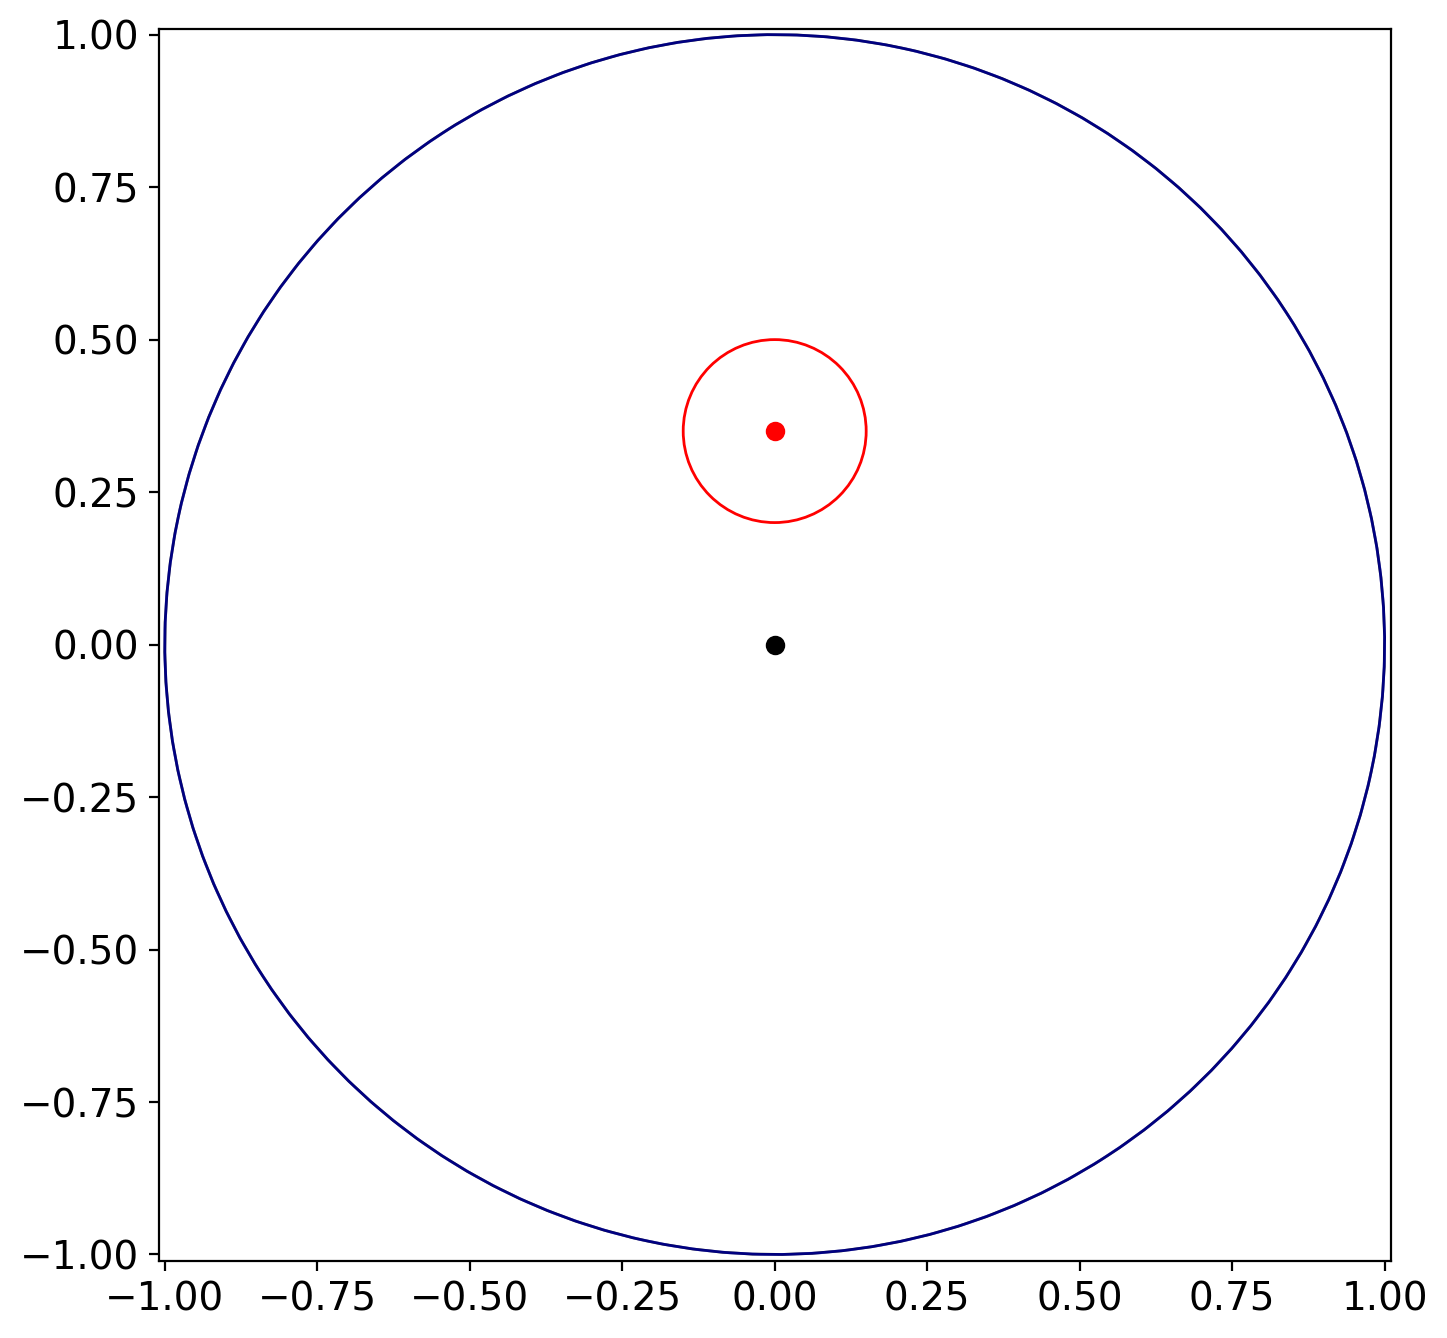

In [4]:
f = 0.0
b0 = 0.35
r_p = 0.15
theta = np.radians(33)
xi = utils.compute_xi(b0, r_p, f, theta)
phi = utils.compute_phi(b0, r_p, f, theta)
utils.draw_oblate_full(b0, r_p,f,theta)

In [5]:
from tqdm.notebook import tqdm
numerical_circ = np.zeros(16)
for n in tqdm(range(16)):
    xr, yr, term, under_occultor, in_star, numerical_circ[n] = sT_bruteforce(f, theta, b0, r_p, n=n, res=1000)

/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


We have to be very careful about how we perform the integrals. The line integral must be taken in the counterclockwise direction and we must only integrate the smaller closed region bounding the planet and star. To do this, I have found that wrapping $\xi$ to the range $-\pi$ to $\pi$ and $\phi$ to the range $\frac{\pi}{2}$ to $\frac{5\pi}{2}$ and sorting ensures that the integral is performed correctly for all angles.

(The reason for the strange bound on $\phi$ is because the integral must be performed such that the star center, which lies on the y axis, must be included in the integral as it sweeps across the planet boundary. Taking the planet's center as the origin, the star's center is at $\frac{3\pi}{2}$, meaning this has to be the center of the bounds. 

In [6]:
semi_analytic_circ = np.zeros(16)

xi = utils.compute_xi(b0, r_p, f, theta)
phi = utils.compute_phi(b0, r_p, f, theta)
xi_2pi = np.sort(np.mod(xi+np.pi, 2*np.pi)-np.pi)
phi_2pi = np.pi/2 + np.sort(np.mod(phi-np.pi/2, 2*np.pi))
phi = utils.compute_phi(b0, r_p, f, theta)
try:
    assert len(phi) != 0
    print("Xi: " + str(np.degrees(xi)))
    print("Xi wrapped: " + str(np.degrees(xi_2pi)))
    print("Xi subtends: " + str(np.degrees(xi_2pi[1]-xi_2pi[0])))
    print("Phi: " + str(np.degrees(phi)))
    print("Phi wrapped: " + str(np.degrees(phi_2pi)))
    print("Phi wrapped subtends: " + str(np.degrees(phi_2pi[1]-phi_2pi[0])))
except:
    phi_2pi = np.array([np.pi / 2, 5 * np.pi / 2])
    xi_2pi = np.array([])
    print("Excepted")
for n in tqdm(range(16)):
    semi_analytic_circ[n] = sT(phi_2pi, xi_2pi, f, theta, b0, r_p, n=n)

Excepted


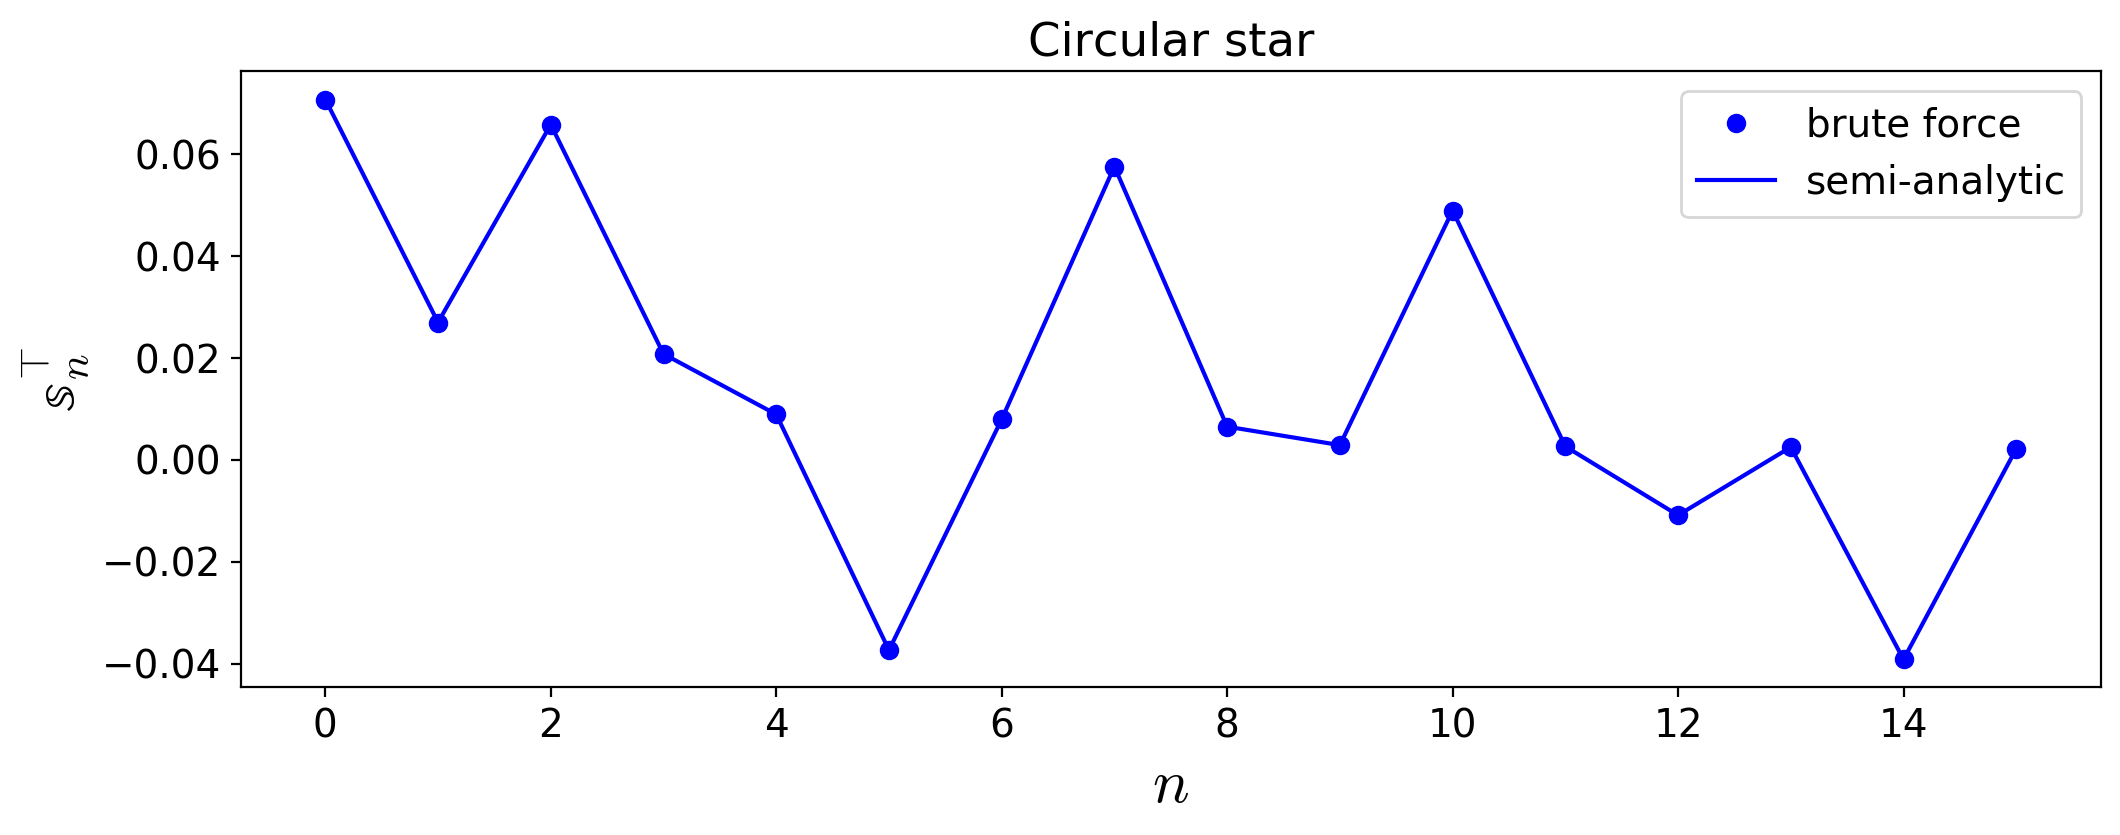

In [7]:
plt.plot(numerical_circ,'bo', label="brute force")
plt.plot(semi_analytic_circ,'b-', label="semi-analytic")

plt.legend()

plt.title("Circular star")
plt.xlabel(r"$n$", fontsize=22)
plt.ylabel(r"$\mathbb{s}_n^\top$", fontsize=22);

## Elliptical case

array([50.78034324, 72.93268411])

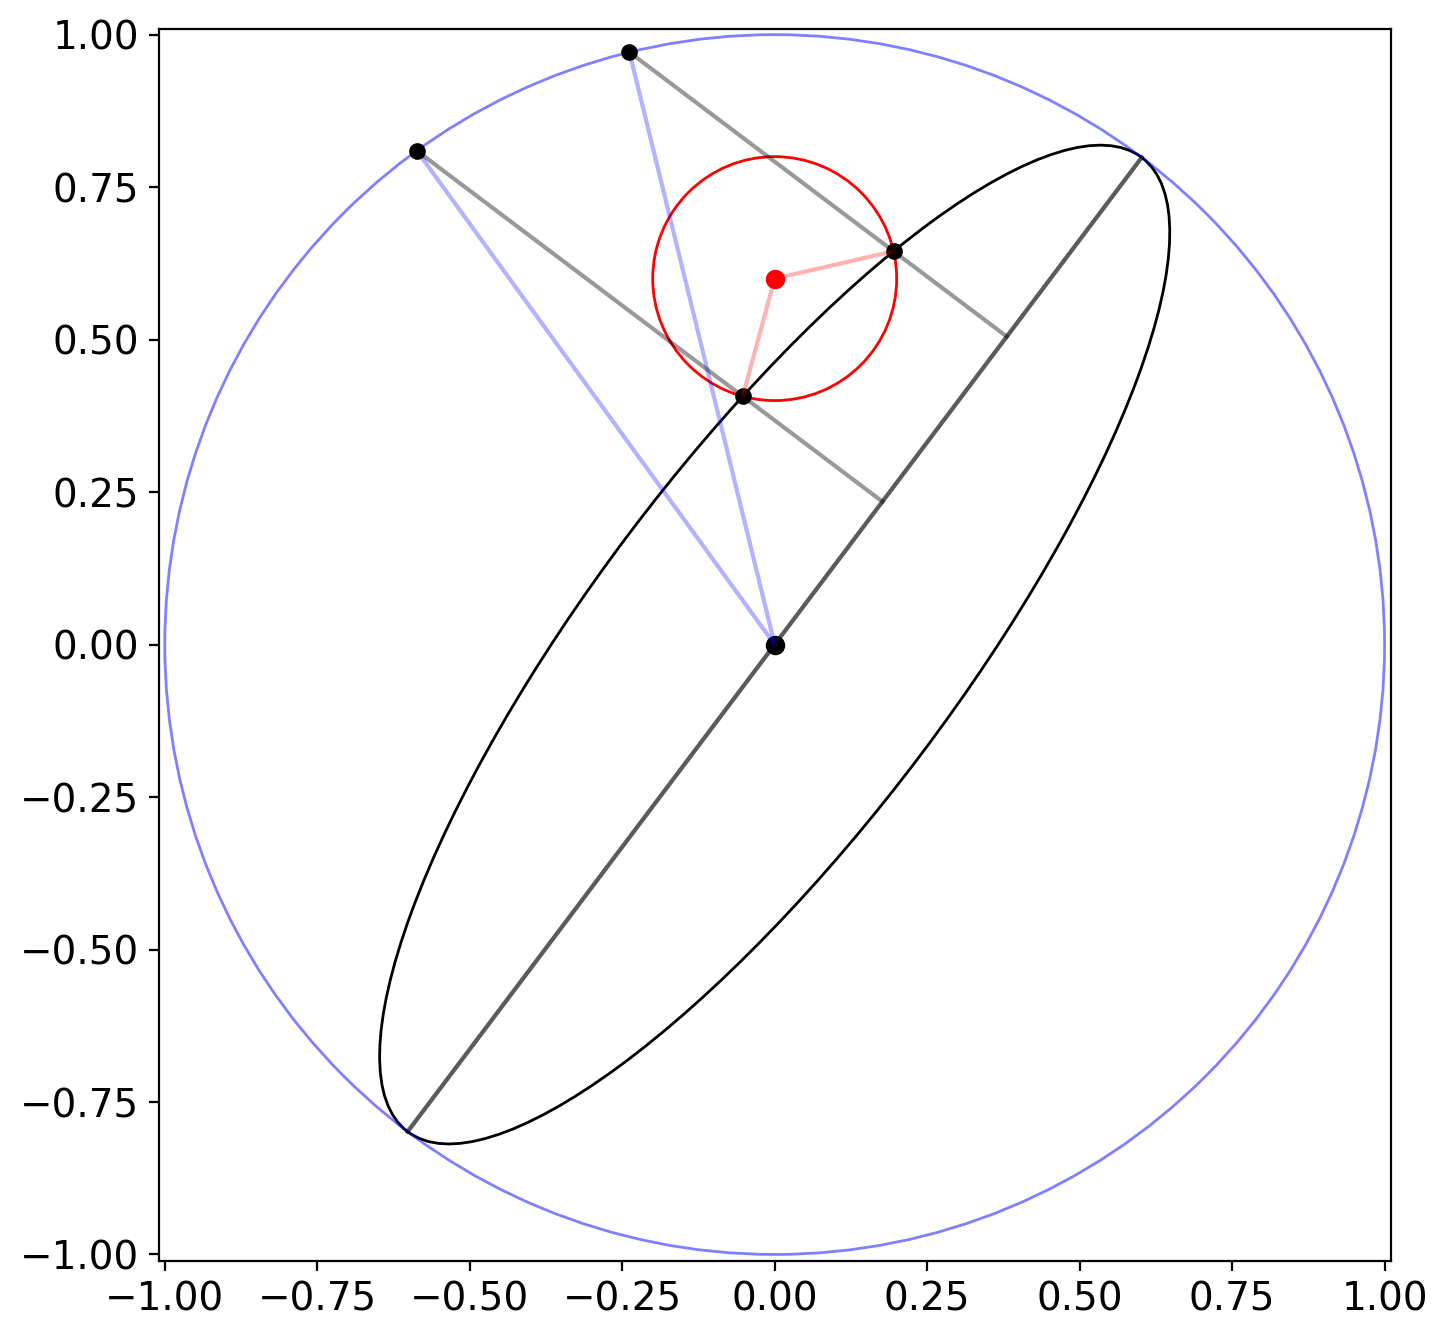

In [8]:
f = 0.7
b0 = 0.6
r_p = 0.2
theta = np.radians(53)
xi = utils.compute_xi(b0, r_p, f, theta)
phi = utils.compute_phi(b0, r_p, f, theta)
utils.draw_oblate_full(b0, r_p,f,theta)

In [9]:
from tqdm.notebook import tqdm
numerical = np.zeros(16)
term = [None for i in range(16)]
for n in tqdm(range(16)):
    xr, yr, term[n], under_occultor, in_star, numerical[n] = sT_bruteforce(f, theta, b0, r_p, n=n, res=1000)

/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [10]:
semi_analytic = np.zeros(16)

xi = utils.compute_xi(b0, r_p, f, theta)
phi = utils.compute_phi(b0, r_p, f, theta)
xi_2pi = np.sort(np.mod(xi+np.pi, 2*np.pi)-np.pi)
phi_2pi = np.pi/2 + np.sort(np.mod(phi-np.pi/2, 2*np.pi))
phi = utils.compute_phi(b0, r_p, f, theta)
try:
    assert len(phi) != 0
    print("Xi: " + str(np.degrees(xi)))
    print("Xi wrapped: " + str(np.degrees(xi_2pi)))
    print("Xi subtends: " + str(np.degrees(xi_2pi[1]-xi_2pi[0])))
    print("Phi: " + str(np.degrees(phi)))
    print("Phi wrapped: " + str(np.degrees(phi_2pi)))
    print("Phi wrapped subtends: " + str(np.degrees(phi_2pi[1]-phi_2pi[0])))
except:
    xr = b0 * np.sin(theta)
    yr = b0 * np.cos(theta)
    in_star = (xr ** 2) + (yr ** 2)/(1-f)**2 <= 1
    if in_star:
        phi_2pi = np.array([np.pi / 2, 5 * np.pi / 2])
    else:
        phi_2pi = np.array([])
    xi_2pi = np.array([])
    print("Excepted")
for n in tqdm(range(16)):
    semi_analytic[n] = sT(phi_2pi, xi_2pi, f, theta, b0, r_p, n=n)

Xi: [50.78034324 72.93268411]
Xi wrapped: [50.78034324 72.93268411]
Xi subtends: 22.15234086816292
Phi: [  12.95764988 -105.19158612]
Phi wrapped: [254.80841388 372.95764988]
Phi wrapped subtends: 118.14923599579522


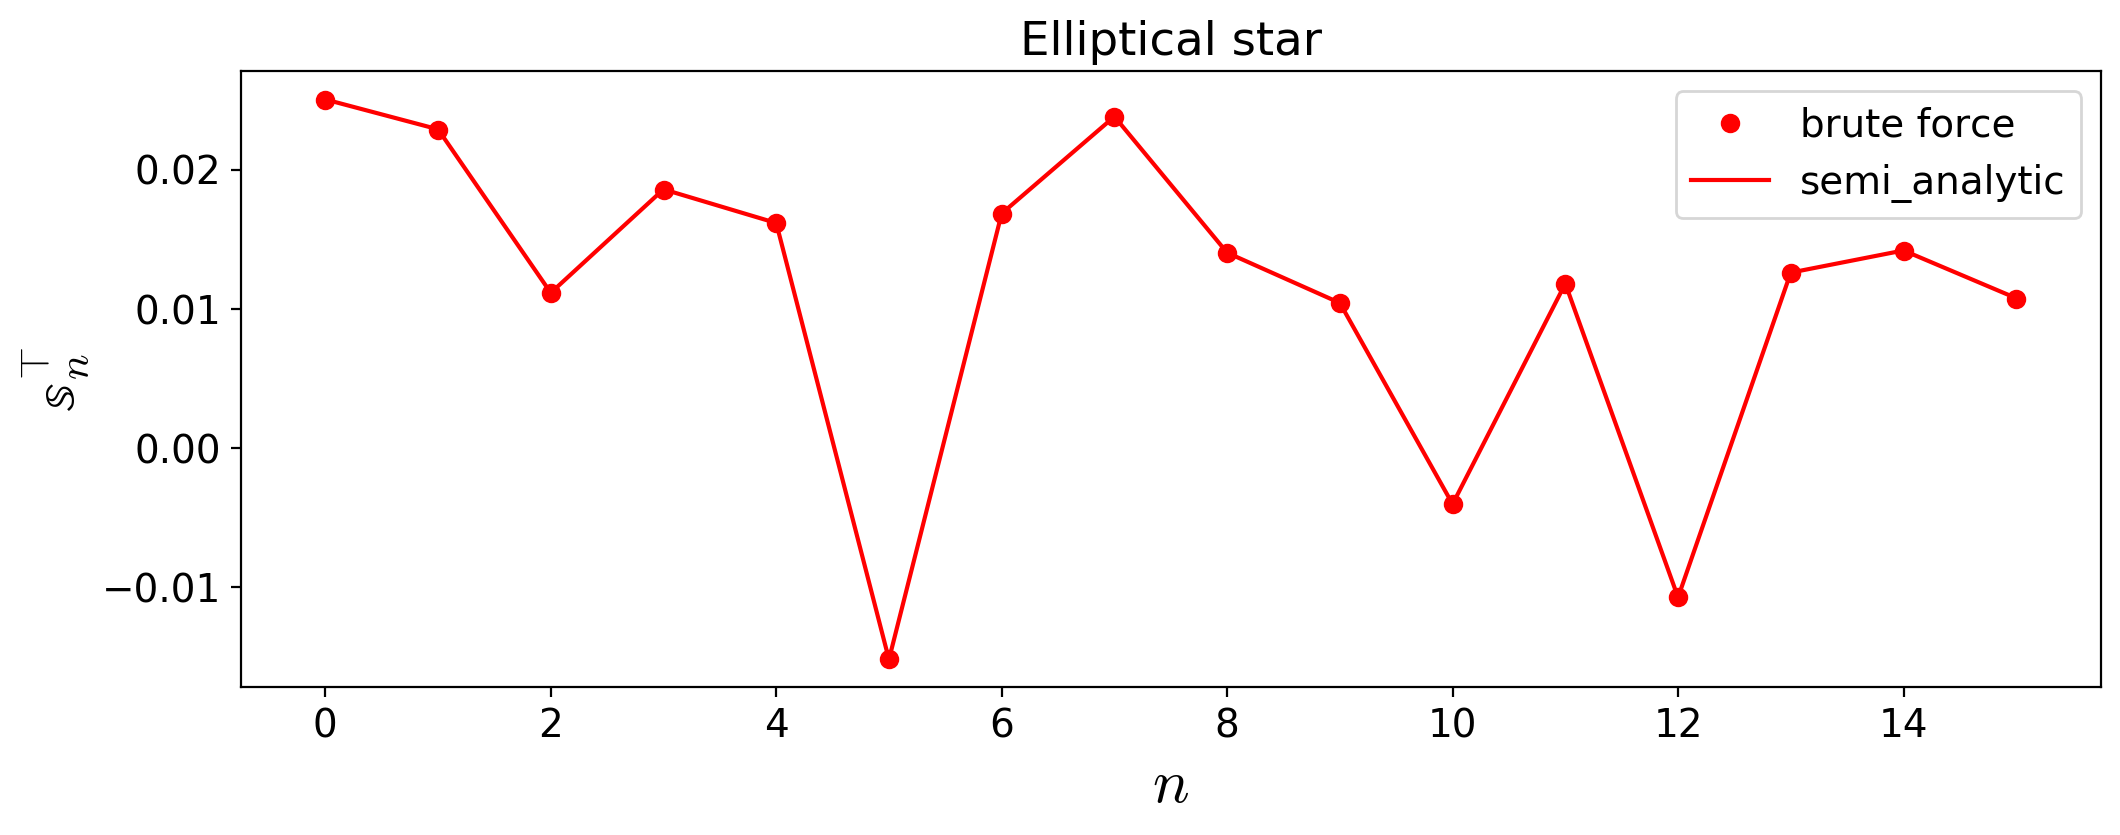

In [11]:
plt.plot(numerical,'ro', label="brute force")
plt.plot(semi_analytic,'r-', label="semi_analytic", ms=10)

plt.legend()

plt.title("Elliptical star")
plt.xlabel(r"$n$", fontsize=22)
plt.ylabel(r"$\mathbb{s}_n^\top$", fontsize=22);

In [12]:
import starry
A = np.array(starry.Map(3).ops.A.eval().todense())
semi_analytic_norm = np.zeros(16)
for n in tqdm(range(16)):
    semi_analytic_norm[n] = tT_numerical(np.array([np.pi/2,5*np.pi/2]), 1-f, theta, n=n)

Pre-computing some matrices... Done.


In [13]:
1-((semi_analytic@A))

array([0.99202903, 0.98975397, 0.99385357, 0.99368857, 0.98961577,
       0.99021513, 1.00290692, 0.99375789, 1.00532661, 0.99930261,
       0.98833386, 0.99956704, 1.00767425, 0.99934891, 1.00552329,
       1.01085029])